<a href="https://colab.research.google.com/github/mkhfagy/Python/blob/master/Kaggle_Atta_MDt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1lqPtliwLnYXJpZhsoa4OdHx2IGmmPc9o'
output = 'MD.zip'
gdown.download(url, output, quiet=False)

In [ ]:
image_folder = 'MD/Images'
folder_name = 'MD/pickle'
tr_file_name = 'train.pkl'
te_file_name = 'test.pkl'
chexnet_weights = 'MD/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add, MaxPooling2D, GRU, AveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [ ]:
train = pd.read_pickle(os.path.join(folder_name,tr_file_name))
test = pd.read_pickle(os.path.join(folder_name,te_file_name))
train.shape,test.shape

In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression for faster training.'
%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

# **Modelling**

## **Hyperparameters**

In [ ]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

## **Creating an input data pipeline**

In [ ]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    # self.aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    # #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    # self.aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_batch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

## **CHeXNET Model (pretrained)**

[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Denset121 layered model which is trained on 1000s of chest x-ray images for the classification of 14 diseases.We can load the weights of that model and pass the image through that model. The top layer will be ignore.

In [ ]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights,input_size = input_size):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,)) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of the chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-3].output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
  #since we are using attention here
  return chexnet

## Attention Model

References:
[attention](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)

In [ ]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

### Image Encoder Layer

In [ ]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    self.avgpool = AveragePooling2D()
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data) #op shape: (None,7,7,1024)
    op = self.avgpool(op) #op shape (None,3,3,1024)
    op = tf.reshape(op,shape = (-1,op.shape[1]*op.shape[2],op.shape[3])) #op shape: (None,9,1024)
    return op 

### Encoder

In [ ]:
def encoder(image1,image2,dense_dim = dense_dim,dropout_rate = dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Image_encoder()
  bkfeat1 = im_encoder(image1) #shape: (None,9,1024)
  bk_dense = Dense(dense_dim,name = 'bkdense',activation = 'relu') #shape: (None,9,512)
  bkfeat1 = bk_dense(bkfeat1)

  #image2
  bkfeat2 = im_encoder(image2) #shape: (None,9,1024)
  bkfeat2 = bk_dense(bkfeat2) #shape: (None,9,512)


  #combining image1 and image2
  concat = Concatenate(axis=1)([bkfeat1,bkfeat2]) #concatenating through the second axis shape: (None,18,1024)
  bn = BatchNormalization(name = "encoder_batch_norm")(concat) 
  dropout = Dropout(dropout_rate,name = "encoder_dropout")(bn)
  return dropout

Global Attention equations



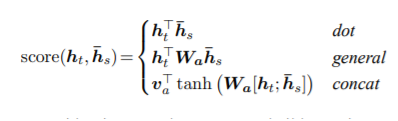


Here I will be using concat score of global attention.
[reference](https://github.com/uzaymacar/attention-mechanisms#local-attention)

### Global Attention Layer

In [ ]:
class global_attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self,dense_dim = dense_dim):
    super().__init__()
    # Intialize variables needed for Concat score function here
    self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
    self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
    self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
      #op (None,98,1)


  def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
    decoder_h = tf.expand_dims(decoder_h,axis=1) #shape: (None,1,dense_dim)
    tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
    tanh_output =  tf.nn.tanh(tanh_input)
    attention_weights = tf.nn.softmax(self.V(tanh_output),axis=1) #shape= batch_size*98*1 getting attention alphas
    op = attention_weights*encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
    context_vector = tf.reduce_sum(op,axis=1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


    return context_vector,attention_weights

In [ ]:
glove = {}
with open('MD/glove/glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

### One Step Decoder

In [ ]:
class One_Step_Decoder(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim ,name = "onestepdecoder"):
    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.embedding = Embedding(input_dim = vocab_size+1,
                                output_dim = embedding_dim,
                                input_length=max_pad,
                                weights = [embedding_matrix],
                                mask_zero=True, 
                                name = 'onestepdecoder_embedding'
                              )
    self.LSTM = GRU(units=self.dense_dim,
                    # return_sequences=True,
                    return_state=True,
                    name = 'onestepdecoder_LSTM'
                    )
    self.attention = global_attention(dense_dim = dense_dim)
    self.concat = Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'onestepdecoder_embedding_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.concat = Concatenate(axis=-1)
    self.add =Add()
  @tf.function
  def call(self,input_to_decoder, encoder_output, decoder_h):#,decoder_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

      here state_h,state_c are decoder states
    '''
    embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    

    context_vector,attention_weights = self.attention(encoder_output,decoder_h) #passing hidden state h of decoder and encoder output
    #context_vector shape: batch_size*dense_dim we need to add time dimension
    context_vector_time_axis = tf.expand_dims(context_vector,axis=1)
    #now we will combine attention output context vector with next word input to the lstm here we will be teacher forcing
    concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
    output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
    #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
    #we need to remove the time axis from this decoder_output
    

    output = self.final(output)#shape = batch_size*decoder vocab size
    return output,decoder_h,attention_weights

### Decoder

In [ ]:
class decoder(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad = max_pad, embedding_dim = embedding_dim,dense_dim = dense_dim,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.output_array = tf.TensorArray(tf.float32,size=max_pad)
    self.max_pad = max_pad
    self.batch_size = batch_size
    self.dense_dim =dense_dim
    
  @tf.function
  def call(self,encoder_output,caption):#,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
    decoder_h, decoder_c = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) #decoder_h, decoder_c
    output_array = tf.TensorArray(tf.float32,size=max_pad)
    for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
      output,decoder_h,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
      output_array = output_array.write(timestep,output) #timestep*batch_size*vocab_size

    self.output_array = tf.transpose(output_array.stack(),[1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
    return self.output_array

### Global Attention Model

In [ ]:
#model creation
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))

encoder_output = encoder(image1,image2) #shape: (None,28,512)

output = decoder()(encoder_output,caption)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [ ]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-2
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])
# model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics= ['accuracy'])

In [ ]:
tf.keras.backend.clear_session()
tb_filename = 'Encoder_Decoder_global_attention/'
tb_file = os.path.join('MD',tb_filename)
model_filename = 'Encoder_Decoder_global_attention.h5'
model_save = os.path.join('MD',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [ ]:
!rm -r 'MD/Encoder_Decoder_global_attention/'

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 9,
          callbacks = my_callbacks
          )

### Tensorboard

In [ ]:
model_filename = 'Encoder_Decoder_global_attention.h5'
model_save = os.path.join('MD',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir 'MD/'

## Predictions

### Bleu score function

We will compute bleu scores 1-gram,2-gram, 3-gram and 4-gram for each sentence.

In [ ]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0))
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [ ]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

### **Greedy Search**

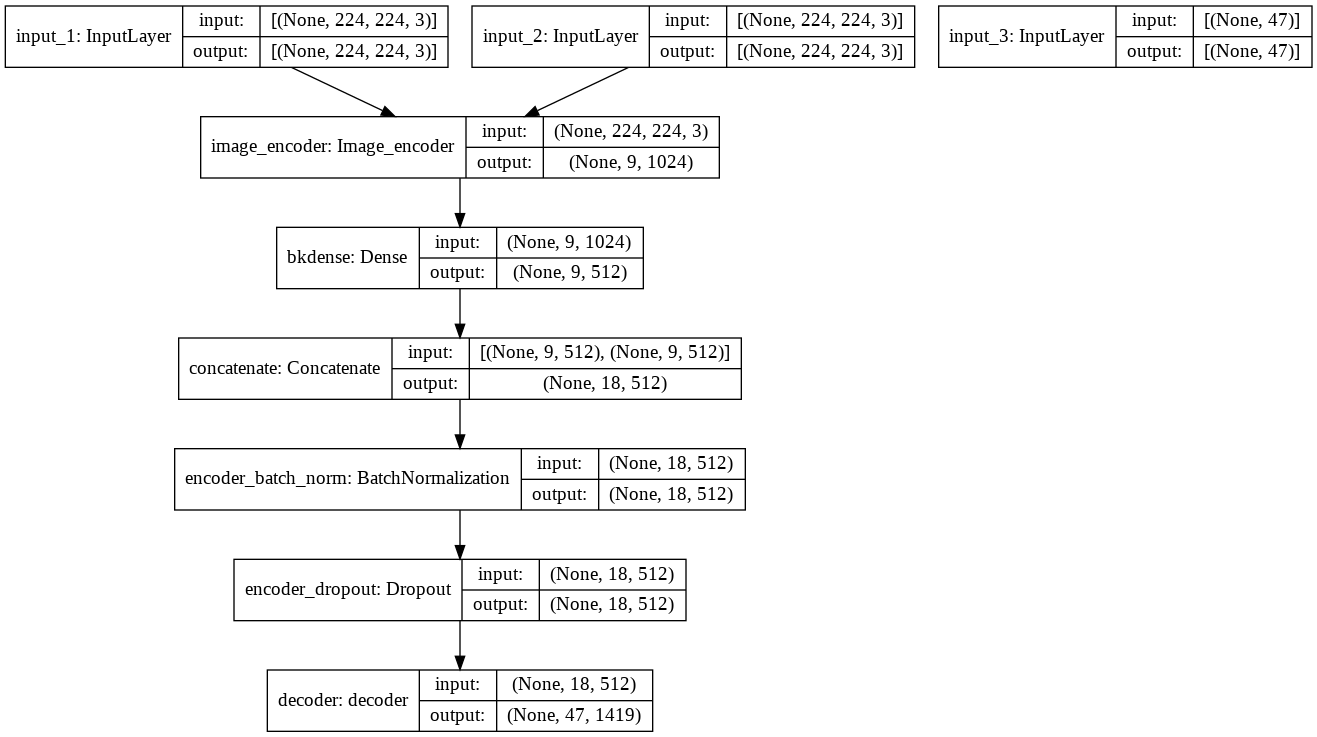

In [ ]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  image1 = model.get_layer('image_encoder')(image1)
  image2 = model.get_layer('image_encoder')(image2)
  image1 = model.get_layer('bkdense')(image1)
  image2 = model.get_layer('bkdense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  enc_op = model.get_layer('encoder_batch_norm')(concat)  
  enc_op = model.get_layer('encoder_dropout')(enc_op) #this is the output from encoder


  decoder_h,decoder_c = tf.zeros_like(enc_op[:,0]),tf.zeros_like(enc_op[:,0])
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    output,decoder_h,attention_weights = model.get_layer('decoder').onestepdecoder(caption,enc_op,decoder_h)#,decoder_c) decoder_c,

    #prediction
    max_prob = tf.argmax(output,axis=-1)  #tf.Tensor of shape = (1,1)
    caption = np.array([max_prob]) #will be sent to onstepdecoder for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [ ]:
%%time
k = -1
image1,image2 = test.image_1.iloc[k],test.image_2.iloc[k]
print(greedy_search_predict(image1,image2,model1))

In [ ]:
%%time
_ = mean_bleu(test,greedy_search_predict)

In [ ]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])
result

### **Beam Search**

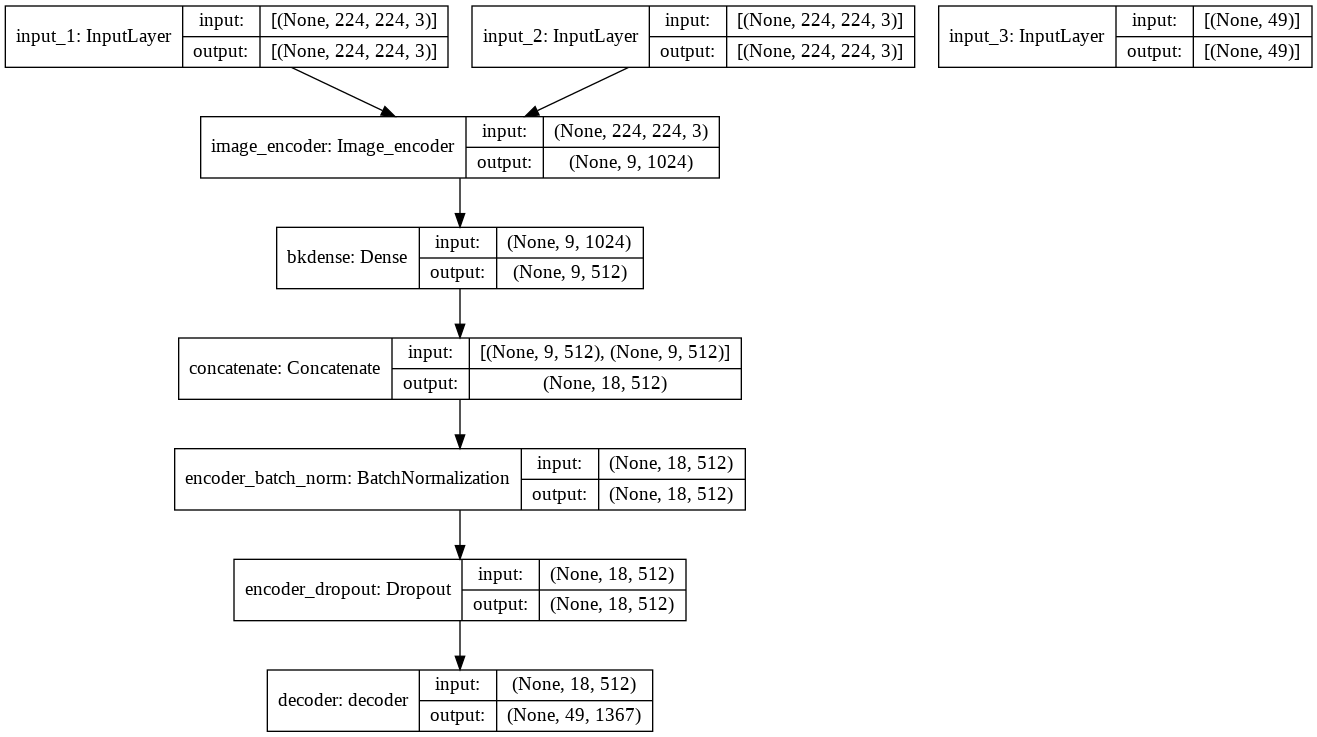

In [ ]:
def encoder_op(image1,image2,model = model1):
  """
  Given image1 and image2 filepath, outputs
  their backbone features which will be input
  to the decoder
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  
  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image1 = model.get_layer('bkdense')(image1)
  image2 = model.get_layer('image_encoder')(image2)
  image2 = model.get_layer('bkdense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  concat = model.get_layer('encoder_batch_norm')(concat)
  concat = model.get_layer('encoder_dropout')(concat)
  return concat

In [ ]:
def beam_search_predict(image1,image2,top_k=3,max_pad = max_pad,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  k = top_k
  cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
  enc_op = encoder_op(image1,image2)
  states = tf.zeros_like(enc_op[:,0]) #state_h only
  seq_score = [[cls_token,0,states]] #[[[3], 0]]
  finished_seq_score = []
  for i in range(max_pad): #traverse through all lengths
    all_candidates = [] #stores all the top k seq along with their scores
    new_seq_score = [] #stores the seq_score which does not have <end> in them
    for s in seq_score: #traverse for all top k sequences
      text_input = s[0][-1] #getting the last predicted output
      states = s[2]
      caption = np.array([[text_input]]) #ip must be in shape (batch_size,seq length,dim)
      output,states,attention_weights =  model.get_layer('decoder').onestepdecoder(caption,enc_op,states) #here output has shape (1,vocab_size)
      top_words = tf.argsort(output[0],direction = 'DESCENDING')[:k] #get the top k words

      seq,score,_ = s
      for t in top_words.numpy():
        #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
        #here since its -(log), lower the score higher the prob
        candidates = [seq+[t],score-np.log(output[0][t].numpy()),states] #updating the score and seq
        all_candidates.append(candidates)
      seq_score = sorted(all_candidates,key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
      #checks for  <end> in each seq obtained
      count = 0
      end_token = tokenizer.word_index['<end>']
      for seq,score,state in seq_score:
        # print('seq,score',seq,score)
        if seq[-1] == end_token: #if last word of the seq is <end>
          finished_seq_score.append([seq,score])
          count+=1
        else:
          new_seq_score.append([seq,score,state])
      k-=count #substracting the no. of finished sentences from beam length
      seq_score = new_seq_score

      if seq_score==[]: #if null array
        break;
      else:
        continue;

  seq_score = finished_seq_score[-1]
  sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
  score = seq_score[1]
      
  return tokenizer.sequences_to_texts([sentence])[0]

In [ ]:
%%time
k = -1
image1,image2 = test.image_1.iloc[k],test.image_2.iloc[k]
print(beam_search_predict(image1,image2))

It took more than 2 min to get a prediction by beam search when k=3. Since its not feasible we will not be using beam search for this method.

# **Inference**

Now we will predict all datapoints with best approach chosen (here it is greedy search) and see the results manually and also compute bleu (1 gram) score.

In [ ]:
%%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search

for index,rows in test.iterrows():
  #greedy search
  predicted_text = greedy_search_predict(rows.image_1,rows.image_2,model1)
  test.loc[index,'prediction_gs'] = predicted_text
  reference = [rows['impression'].split()]
  test.loc[index,'bleu_1_gs'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

In [ ]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search

From the above results, we can see that for at least 61% of the data, the model is predicting captions which are having similiar meanings. It is not doing worse as the baseline model where it was predicting 96% of the test data with the same caption even though we did upsampling and downsampling of the data.

## Random predictions on test data

In [ ]:
def final_caption_pred(image1,image2,method = "beam",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
  method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  elif method in ['beam','b']:
    pred_caption = beam_search_predict(image1,image2,top_k = top_k,model = model)
  else:
    print("Enter 'b' or 'beam' for beam search and 'g' or 'greedy' for greedy search")
  
  return pred_caption

In [ ]:
def inference(image1,image2,true_caption,model=model1,top_k = None,image_size = (10,20)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  if type(top_k)==int:
    top_k = [top_k] #changing it to list if top_k given is of int type
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))
  #beam search of top_k
  if top_k != None:
    for i in top_k:
      beam_caption = final_caption_pred(image1,image2,method='b',model=model,top_k = i)
      print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))


### Correct Captions (high bleu score)

In [ ]:
i = test[(test['bleu_1_gs']>0.65)].sample(5).index
for j,k in enumerate(i):
  print(j+1,")")
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)
  print("\n")

### Incorrect Caption (low bleu score)

In [ ]:
i = test[test['bleu_1_gs']<=0.3].sample(5).index
for j,k in enumerate(i):
  print(j+1,")")
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption,top_k = 1)
  print("\n")

We can see from both of the correct and incorrect captions that the model is doing pretty good since it is predicting captions that are near to the true captions except for some. 

We can see that most of the images shown in incorrect captions had similiar meanings to no cardiopulmonary abnormality which is predicted by the model except for 2 and 4 where it predicted more words which changed the meaning. Even then this is performing far better than the baseline model since it was only predicting "no cardiopulmonary abnormaity" 100% of test data. Here there is variability in predictions and also model is able to understand the meanings since for most of the cases where bleu scores were low it was found that the predicted caption had same meaning as of the true caption.

# For comparisons

For comparing the results with other results, we willl predict captions on 6 test data.

In [ ]:
k = 3
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

In [ ]:
k = 536
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

Here we can see that the model has predicted the word atelactasis and basilar which is meaningfully correct. But other sentences are incorrect. Even then this model is showing it understanding a little bit.

In [ ]:
k = 541
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

Even though the wordings are completely different here the model has predicted sentences which is linguitically similiar.

In [ ]:
k = 562
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

Here also same as above.

In [ ]:
k = 451
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

The model has predicted the caption correctly.

In [ ]:
k = 456
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

Here also the model has predicted the caption correctly.

# Conclusion

In [ ]:
result

This model performed better than simple baseline model since it produced captions which had higher variablity and also remained lingusitically similiar. Even then we can see that most of datapoints were of normal chest or no disease category we need to collect more dataset which have x-rays of patients having diseases so that to improve the model's performance. Even the model predicted tough captions which had similiar meaning to the true ones. Beam search was found to take large amount of time in predicting even 1 caption so it was discarded. 
